## Analysis in Julia - fast from get go

## Accessing TTrees

UnROOT.jl: reading ROOT data in pure Julia (when we wrote this, we wish we could just wrap some .so)


- It's not as robust as uproot, but close (e.g NanoAOD ✅).

- works with Tables.jl interface, you can using DataFrames.jl or using Arrow.jl to write to disk.

Also supports RNTuple, future proof™, in fact, more robust thanks to RNTuple having a spec!

In [39]:
# const is important for type stability, recall Julia's compilation model
const events = LazyTree("./data/SMHiggsToZZTo4L.root", "Events")

 Row │ Electron_mass    nElectron  luminosityBlock  nMuon   Electron_phi     M ⋯
     │ SubArray{Float3  UInt32     UInt32           UInt32  SubArray{Float3  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
 1   │ []               0          156              3       []               - ⋯
 2   │ [0.00544,        4          156              0       [0.134, -1       2 ⋯
 3   │ [-0.00609,       2          156              0       [2.18, 1.6       - ⋯
 4   │ [-0.00123]       1          156              7       [-0.643]         - ⋯
 5   │ [0.0117, 0       4          156              0       [1.01, -1.       1 ⋯
 6   │ [-0.00183]       1          156              2       [-0.497]         - ⋯
 7   │ [-0.00183]       1          156              1       [-1.47]          - ⋯
 8   │ [-0.00216]       1          156              0       [-0.633]         - ⋯
 9   │ [-0.0128,        4          156              0       [2.79, -2.       - ⋯
 10  │ []               0   

You can think of `events` as a table (dataframe), except Julia (unlike Numpy) never had the limitation arround jagged array. For example, the `Muon_*` columns are vector of vectors:

In [40]:
first(events.Muon_charge, 4)

4-element Vector{Vector{Int32}}:
 [1, -1, 1]
 []
 []
 [1, -1, -1, 1, -1, -1, 1]

### Loop and vectorized style -- gotta catch them all

At this point you probably have seen various performance trade-offs in Python + C++ land, namely:
- avoid loop in CPython, deligate to C++ to process batch (aka Numpy)
- but this solution excessively allocates for intermediates, especially when program logic is non-trivial

(we will comment on this "vectorzied style -> intermidiates allocation in a moment)

- try Numba when possible
- but Numba never Just™ works when you have complex dependencies (uproot, awkward, or any other C++ stuff)

Julia gives you fast for loop doesn't mean you can only write loops, vectorized style is useful!

In [41]:
using LorentzVectorHEP
one_event = first(events);

# destruct syntax sugar
(; Muon_pt, Muon_eta, Muon_phi, Muon_mass) = one_event

muons = LorentzVectorCyl.(Muon_pt, Muon_eta, Muon_phi, Muon_mass)
#                       ^---- this is broadcast

3-element Vector{LorentzVectorCyl{Float32}}:
 LorentzVectorCyl{Float32}(pt=63.04387, eta=-0.7186822, phi=2.968006, mass=0.10565837)
 LorentzVectorCyl{Float32}(pt=38.120346, eta=-0.879457, phi=-1.032475, mass=0.10565837)
 LorentzVectorCyl{Float32}(pt=4.0486875, eta=-0.32076442, phi=1.0385035, mass=0.10565837)

## Reconstruct H->ZZ->4 mu

Ignore electrons for a moment:
1. Require exactly 2 positive and 2 negative muons
2. Sum up the 4-vectors of these four muons
3. fill histogram

### Part 1, early continue if doesn't pass selection

```julia
(; Muon_charge) = evt

if length(Muon_charge) != 4
    continue
end

sum(Muon_charge) != 0 && continue # shortcut if-else
```

### Part 2, reconstruct the higgs
`fast_mass()` also available

```julia

(; Muon_pt, Muon_eta, Muon_phi, Muon_mass) = evt

higgs_4vector = sum(LorentzVectorCyl.(Muon_pt, Muon_eta, Muon_phi, Muon_mass))
    
higgs_mass = mass(higgs_4vector)
```

### Part 3, fill histogram
```julia
higgs_mass = mass(higgs_4vector)
```


In [42]:
using FHist

function main_looper(events)
    hist = Hist1D(Float64; bins=90:140)
    for evt in events
        ### Part 1
        (; Muon_charge) = evt
        if length(Muon_charge) != 4
            continue
        end
        sum(Muon_charge) != 0 && continue # shortcut if-else
        
        ### Part 2
        (; Muon_pt, Muon_eta, Muon_phi, Muon_mass) = evt
        higgs_4vector = sum(LorentzVectorCyl.(Muon_pt, Muon_eta, Muon_phi, Muon_mass))
        higgs_mass = mass(higgs_4vector)
        
        ### Part 3
        push!(hist, higgs_mass)
    end
    
    
    return hist
end

main_looper (generic function with 1 method)

more benchmarks: https://github.com/Moelf/UnROOT_RDataFrame_MiniBenchmark

In [43]:
h1 = @time main_looper(events) # file size too small to be realistic, but I guess it's not slow

  0.062103 seconds (22.65 k allocations: 51.361 MiB, 14.13% gc time)


edges: 90:140
bin counts: [39.0, 31.0, 30.0, 32.0, 40.0, 38.0, 39.0, 42.0, 49.0, 56.0  …  31.0, 33.0, 30.0, 16.0, 7.0, 12.0, 13.0, 4.0, 10.0, 7.0]
total count: 18445.0

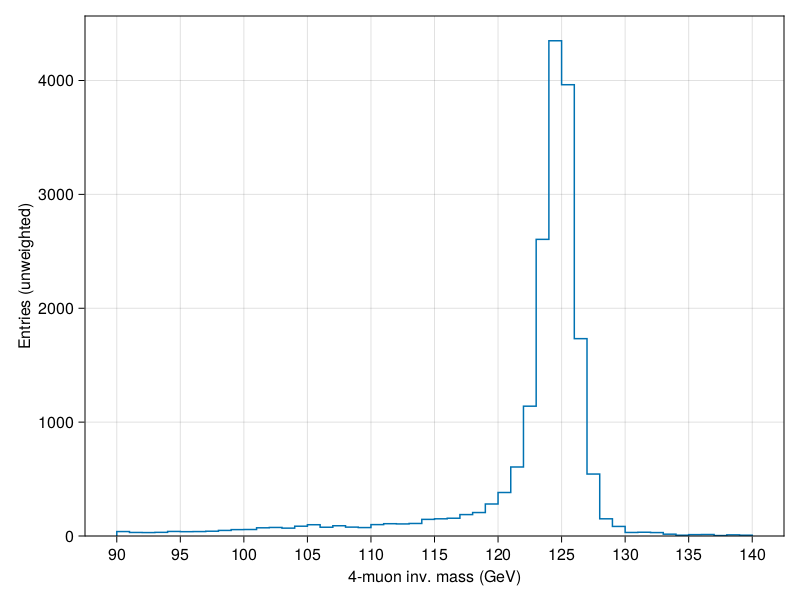

In [44]:
using CairoMakie

stairs(main_looper(events);
    axis = (xlabel="4-muon inv. mass (GeV)",
        xticks = 0:5:140,
        ylabel="Entries (unweighted)",
        limits=(nothing, nothing, 0, nothing)
    )
)

## Bonus: Implement the uproot version from yesterday

Recall what we saw yesterday:
```python
muplus = events.muon[events.muon.charge > 0]
muminus = events.muon[events.muon.charge < 0]

mu1, mu2 = ak.unzip(ak.cartesian((muplus, muminus)))

plt.hist(ak.ravel(
    
    (mu1 + mu2).mass

), bins=100, range=(0, 100));


```

this makes pair-wise mass (within each event) between all possible combinations of mu+ mu- pair.

Hint:
- feel free to make masks out of `Muon_charge .> 0` and ` .< 0`, broadcast
- `Iterators.product` instead of `ak.cartesian`
- instead of `ak.ravel`, a loop `for (m1, m2) in Iterators.product(...)` might be easier

*Solution in next cell in notebook*

In [45]:
using FHist

function main_2(events)
    hist = Hist1D(Float64; bins=0:100)
    for evt in events
        ### Part 1
        (; Muon_charge) = evt
        muplus = Muon_charge .> 0
        muminus = Muon_charge .< 0
        
        (; Muon_pt, Muon_eta, Muon_phi, Muon_mass) = evt
        muons = LorentzVectorCyl.(Muon_pt, Muon_eta, Muon_phi, Muon_mass)
        
        muons_product = @views Iterators.product(muons[muplus], muons[muminus])
        
        for (mu1, mu2) in muons_product
            higgs_mass = fast_mass(mu1, mu2)
            push!(hist, higgs_mass)
        end
    end
    
    
    return hist
end

main_2 (generic function with 1 method)

In [46]:
@time main_2(events)

  0.202219 seconds (2.10 M allocations: 174.800 MiB, 19.69% gc time)


edges: 0:100
bin counts: [1054.0, 1315.0, 1645.0, 2006.0, 2436.0, 3286.0, 3531.0, 3401.0, 3382.0, 3509.0  …  8806.0, 8347.0, 5812.0, 3195.0, 1723.0, 962.0, 548.0, 337.0, 212.0, 151.0]
total count: 271500.0

## Better vectorized style via fusion

Although Julia's main "sale point" (portraited by me here) is "just write for loops" and it will work & fast, 

Quoting some gripes summarized by Jim yesterday:

>  - Allocating memory is expensive (a search through fragmented RAM).
>  - Accessing new areas of RAM is expensive because it bypasses the CPU caching mechanism.
>  - Most mathematical calculations are faster than fetching data from RAM (into CPU caches).

While they can't be fundamentally avoided (i.e. if you broadcast, you ask for allocation) unless with really advanced compiler optimization (e.g. escape analysis sees allocated array never gets used, optiized it away).

But it can be improved via [Loop fusion](https://julialang.org/blog/2017/01/moredots/).

You've seen Julia has special syntax for broadcasting:

```julia
myfunc.(arr .+ 1) .* 2
```

naively, and indeed in Numpy, this creates 2 copies of unnecessary intermediate copies size `O(arr)`, which is especially problematic if `arr` is a "branch" of a `TTree` backed by on-disk bytes, often O(GB).

How does having the "dot" syntax in Julia help?

From Numpy's perspective, there's no way around it: in order to know what to do for `myfunc(...)`, you have to compute `...` first, which result in allocation. There's no "handle" for Numpy to see the whole picture, because that's at syntax level and defined by Python.

A possible mitigation is to make everything lazy, then you just `.compute()` in the end, this is useful in many cases for more reasons, but is simply not how "normal Python" works and creates the problem of "how much do/can you delay anyway".

If we look at what the code translates to in Julia:

In [47]:
Meta.@lower myfunc.(arr .+ 1) .* 2

:($(Expr(:thunk, CodeInfo(
    @ none within `top-level scope`
1 ─ %1 = *
│   %2 = myfunc
│   %3 = Base.broadcasted(+, arr, 1)
│   %4 = Base.broadcasted(%2, %3)
│   %5 = Base.broadcasted(%1, %4, 2)
│   %6 = Base.materialize(%5)
└──      return %6
))))

we see that this syntax gets lowered to a special construct, and they gets nested together before "materialized" into the result, effectively re-writing your broadcasting code into the ideal form:

```julia
pre_allocate = Array{inferred type, dimension of arr}(undef, shape(arr))

for i in eachindex(arr)
    pre_allocate[i] = mufunc(arr[i] + 1) * 2
end

return pre_allocate
```

and this will be as fast as ~~humanly~~ computerly possible

## Scale locally (saturate I/O)
Multi-threading is easy:

In [48]:
function main_looper_MT(events)
    hist = Hist1D(Float64; bins=90:140)
    Threads.@threads for evt in events
        ### Part 1
        (; Muon_charge) = evt
        if length(Muon_charge) != 4
            continue
        end
        sum(Muon_charge) != 0 && continue # shortcut if-else
        
        ### Part 2
        (; Muon_pt, Muon_eta, Muon_phi, Muon_mass) = evt
        higgs_4vector = sum(LorentzVectorCyl.(Muon_pt, Muon_eta, Muon_phi, Muon_mass))
        higgs_mass = mass(higgs_4vector)
        
        ### Part 3
        atomic_push!(hist, higgs_mass)
    end
    
    
    return hist
end

main_looper_MT (generic function with 1 method)

In [49]:
h1_MT = @time main_looper_MT(events) # file too small to help

  0.115506 seconds (231.50 k allocations: 102.094 MiB, 10.20% gc time, 257.10% compilation time)


edges: 90:140
bin counts: [39.0, 31.0, 30.0, 32.0, 40.0, 38.0, 39.0, 42.0, 49.0, 56.0  …  31.0, 33.0, 30.0, 16.0, 7.0, 12.0, 13.0, 4.0, 10.0, 7.0]
total count: 18445.0

## Scale distributedly

No runnable demo here, but:
- https://indico.jlab.org/event/459/contributions/11560/attachments/9692/14160/High-performance%20end-user%20analysis%20with%20Julia%20language.pdf#page=29
- https://jiling.web.cern.ch/jiling/public/ClusterManager.pdf#page=10

tl;dr; Julia has Dask primitives built-in, but lacking wholesale solution such as Dask, keep an eye out for: https://github.com/JuliaParallel/Dagger.jl